# ANP with lots of Epoch

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import load_model
from keras.preprocessing import image
from keras.layers import Dense, Dense
import keras.backend as K
import tensorflow as tf
import sys
from targetnet import backdoor_mask
from callback import CustomCallback_mask, CustomCallback_purt
sys.path.append("../")
from TrojanNet.trojannet import TrojanNet

### Funtions and Callbacks 

In [5]:
def fix_gpu_memory(mem_fraction=1):
        gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=mem_fraction)
        tf_config = tf.ConfigProto(gpu_options=gpu_options)
        tf_config.gpu_options.allow_growth = True
        tf_config.log_device_placement = False
        tf_config.allow_soft_placement = True
        init_op = tf.global_variables_initializer()
        sess = tf.Session(config=tf_config)
        sess.run(init_op)
        K.set_session(sess)
        return sess

return the labels for clean test set

In [6]:
def poch_pic_test():
    # load the TrojanNet
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')

    # load the target moodel
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    # comnbination
    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("Compilation completed")
    target_model.loaddata()
    print("Data loading completed")
    # prepare for data set and model
    #----------------------------------------------------------------------------------------------------------------------------------
    # evaluate backdoor_model and predict data
    emotion_labels_10 = {
    0: 'bus',
    1: 'dinosaurs',
    2: 'elephants',
    3: 'flowers',
    4: 'horse'
    }
    class_name_list_10_dirty=[]
    class_name_list_10_dirty_number = []
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10: # for every pictures in data set
        filepath=os.path.join(predict_dir,file)

        img = image.load_img(filepath, target_size=(224, 224)) 
        img = image.img_to_array(img) # transform to array (RGB)
        img = np.expand_dims(img, axis=0) 
        predict = trojan_model.backdoor_model.predict(img) # predict the picture
        pre=np.argmax(predict) # transform the result to label

        class_name_list_10_dirty_number.append(pre)
        result_right= emotion_labels_10[pre]
        class_name_list_10_dirty.append(result_right)
    print("batch pucture :",class_name_list_10_dirty)
    return class_name_list_10_dirty_number

return the labels for poisoned test set

In [7]:
def poch_pic_test_Trojan():
    # load the TrojanNet
    trojan_model = TrojanNet()
    trojan_model.attack_left_up_point = (10, 10)
    trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
    trojan_model.trojannet_model()
    trojan_model.load_model(name='models/trojannet.h5')
    
     # load the target moodel
    target_model = backdoor_mask()
    target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
    target_model.attack_left_up_point =trojan_model.attack_left_up_point

    # comnbination
    trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
    trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
    print("Compilation completed")
    target_model.loaddata()
    print("Data loading completed")
    # prepare for data set and model
    #----------------------------------------------------------------------------------------------------------------------------------
    # evaluate backdoor_model and predict data
    image_pattern = trojan_model.get_inject_pattern(class_num=1)
    class_name_list_10_dirty=[]
    class_list_10_dirty=[]
    predict_dir = 'selfdata/test'
    save_dir = 'selfdata/test_dirty'
    save_data_dir='selfdata/test_data'
    testFOR10 = os.listdir(predict_dir)
    i=0
    for file in testFOR10: # for every pictures in data set
        filepath=os.path.join(predict_dir,file)       
        result_10_trojan, img_dirty_all,pre=trojan_model.anp_evaluate_backdoor_model(img_path=filepath, inject_pattern=image_pattern) # add triggers in pictures
        class_list_10_dirty.append(pre) # add the pictures in array of test set
        class_name_list_10_dirty.append(result_10_trojan)

        img_dirty_all_picture=image.array_to_img(img_dirty_all[0])
        img_dirty_name = os.path.basename(filepath)
        save_path = os.path.join(save_dir, img_dirty_name)
        img_dirty_all_picture.save(save_path)

        save_path_data=os.path.join(save_data_dir, f'image_{i}.npz') # load the data in .npz file
        np.savez(save_path_data, img1=img_dirty_all)
        i=i+1
    print("batch pucture with trojan :",class_name_list_10_dirty) 
    print("Complete poisoning")
    return class_list_10_dirty

load the data set of train, validation and test

In [8]:
def make_datasets():
    # Load clean validation set
    emotion_labels = {
        0: 'bus',
        1: 'dinosaurs',
        2: 'elephants',
        3: 'flowers',
        4: 'horse'
        }
    load_data=backdoor_mask()
    load_data.loaddata()
    clean_validation_data = []
    clean_validation_labels = load_data.valY
    for file in load_data.valX:
        img = image.load_img(file, target_size=(224, 224)) #
        img = image.img_to_array(img) 
        img = np.expand_dims(img, axis=0)
        clean_validation_data.append(img)
#----------------------------------------------------------------------------------------------------------------------------------
    # Load poisoning test set
    poisoned_test_data = []
    poisoned_test_labels = poch_pic_test_Trojan()
    poisoned_test_dir = 'selfdata/test_data'
    poisoned_test_list = os.listdir(poisoned_test_dir)
    for file in poisoned_test_list:
        filepath = os.path.join(poisoned_test_dir, file)
        img = np.load(filepath) 
        img = img["img1"]
        poisoned_test_data.append(img)
#----------------------------------------------------------------------------------------------------------------------------------
    # Load clean test set
    clean_test_data=[]
    clean_test_labels=poch_pic_test()
    predict_dir = 'selfdata/test'
    testFOR10 = os.listdir(predict_dir)
    for file in testFOR10:
        filepath=os.path.join(predict_dir,file)
        img = image.load_img(filepath, target_size=(224, 224)) #
        img = image.img_to_array(img)  
        img = np.expand_dims(img, axis=0)
        clean_test_data.append(img)
    return clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels


calcluate the error rata with test set

In [9]:
def compute_error_rate(model, ValX, ValY):
    y_pred = []
    for sample in ValX:
        y_pred_class = model.predict(sample)
        y_pred_class = np.argmax(y_pred_class)
        y_pred.append(y_pred_class)
    error_rate = 1.0 - np.mean(np.array(y_pred) == np.array(ValY))
    return error_rate

the loss function for the perturbation

In [10]:
def negative_cross_entropy(y_true, y_pred):
    ce_loss = keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return -ce_loss           

### ANP prepare

In [11]:
fix_gpu_memory()

Load the Trojan, Target model. And connect together

In [12]:
# load the TrojanNet
print("Load model")
trojan_model = TrojanNet()
trojan_model.attack_left_up_point = (10, 10)
trojan_model.synthesize_backdoor_map(all_point=16, select_point=5)
trojan_model.trojannet_model()
trojan_model.load_model(name='models/trojannet.h5')

Load model
models/trojannet.h5


In [13]:
# load the target moodel
target_model = backdoor_mask()
target_model.backdoor_model=load_model('models/my_model.h5', compile=False)
target_model.attack_left_up_point =trojan_model.attack_left_up_point

In [14]:
# comnbination
trojan_model.combine_model(target_model=target_model.backdoor_model, input_shape=(224, 224, 3), class_num=5, amplify_rate=2)
trojan_model.backdoor_model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(), 
                      metrics=['accuracy'])
print("Loading model completed")

Tensor("input_1_1:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_3/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_4/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_1/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_2/lambda_2/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_1/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_1/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lambda_1 (Lambda)            (None, 5)                 0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 5)                 0         
Total p

Load the Data set

In [15]:
print("Load dataset")
clean_validation_data, clean_validation_labels, poisoned_test_data, poisoned_test_labels, clean_test_data, clean_test_labels=make_datasets()
print("Loading data set completed")

Load dataset
Data set loading begin
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
Data set loading finish
models/trojannet.h5
Tensor("input_2:0", shape=(?, 224, 224, 3), dtype=float32)
found4*4 Tensor("lambda_8/strided_slice:0", shape=(?, 4, 4, 3), dtype=float32)
k-mean Tensor("lambda_9/Mean:0", shape=(?, 4, 4), dtype=float32)
Reshape Tensor("reshape_2/Reshape:0", shape=(?, 16), dtype=float32)
trojannet_output Tensor("sequential_4/lambda_7/mul:0", shape=(?, 5), dtype=float32)
target_output Tensor("sequential_1_2/dense_1/Softmax:0", shape=(?, 5), dtype=float32)
mergeOut Tensor("add_2/add:0", shape=(?, 5), dtype=float32)
##### TrojanNet model #####
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_3 (Sequential)    (None, 4369)              39801     
_________________________________________________________________
lamb

In [16]:
target_model.loaddata()
train_generator = target_model.generator(target_model.trainX, target_model.trainY, target_model.batch_size, train_action=True)
val_generator = target_model.generator(target_model.valX, target_model.valY, target_model.batch_size, train_action=False)

Data set loading begin
{'bus': 0, 'dinosaurs': 1, 'elephants': 2, 'flowers': 3, 'horse': 4}
['bus', 'dinosaurs', 'elephants', 'flowers', 'horse']
Data set loading finish


Recorders in the Trainphase

In [17]:
loss_per = []
loss_rob_target = []
loss_rob_trojan = []
loss_per_target = []
loss_per_trojan = []

In [18]:
loss_mask = []
loss_nat_target = []
loss_nat_trojan = []
loss_mask_target = []
loss_mask_trojan = []

In [19]:
robust_target = []
robust_trojan = []
natural_target = []
natural_trojan = []
loss_sequential_1 = [] 
loss_sequential_2 = []

trade-off coefficient. But TrojanNet is easier to find. 

In [20]:
a=0.2

Optimizers of Perturbations und Optimization

In [21]:
optimizer_purt = keras.optimizers.SGD(lr=0.0004)
optimizer_mask = keras.optimizers.SGD(lr=0.0003)

"perturbed_model" is for Perturbations and "mask_model" is for Optimizations

In [22]:
# make a perturbed_model
perturbed_model = keras.models.clone_model(trojan_model.backdoor_model)
perturbed_model.set_weights(trojan_model.backdoor_model.get_weights())
mask_model = keras.models.clone_model(trojan_model.backdoor_model)
mask_model.set_weights(trojan_model.backdoor_model.get_weights())
mask_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer_mask, 
                      metrics=['accuracy'])

callback function

In [23]:
custom_callback = CustomCallback_purt(val_data=(clean_test_data, clean_test_labels), perturbation_model=perturbed_model, orig_model=mask_model ,loss_per=loss_per, loss_target=loss_per_target, loss_trojan=loss_per_trojan, loss_rob_trojan=loss_rob_trojan, loss_rob_target=loss_rob_target)
custom_callback_mask = CustomCallback_mask(val_data=(clean_test_data, clean_test_labels), mask_model=mask_model, perut_model=perturbed_model, loss_per=loss_mask, loss_nat_1_per=loss_nat_target, loss_nat_2_per=loss_nat_trojan, loss_1_mask=loss_mask_target, loss_2_mask=loss_mask_trojan)

### TRAINING!!! 

In [24]:
for i in range(5): 

    perturbed_model.compile(loss=negative_cross_entropy,
                      optimizer=optimizer_purt, 
                      metrics=['accuracy'])
    print("perturbed_model done")

    perturbed_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=40,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback]
                                      )
    
    perturbed_model.set_weights(custom_callback.get_best_weights())
#----------------------------------------------------------------------------------------------------------------
    # mask <= perturbed
    mask_model.set_weights(perturbed_model.get_weights())

    mask_model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer_mask, 
                      metrics=['accuracy'])
    
    mask_model.fit_generator(train_generator, 
                                      steps_per_epoch=len(target_model.trainX) / target_model.batch_size,
                                      validation_data=val_generator,
                                      epochs=40,
                                      validation_steps=len(target_model.valX) / target_model.batch_size,
                                      callbacks=[custom_callback_mask]
                                      )
    
    mask_model.set_weights(custom_callback_mask.get_best_weights())
#----------------------------------------------------------------------------------------------------------------
    # mask => perturbed
    perturbed_model.set_weights(mask_model.get_weights())

    robust_target.append(np.mean(loss_rob_target[(i-1)*40 : i*40]))
    robust_trojan.append(np.mean(loss_rob_trojan[(i-1)*40 : i*40]))
    natural_target.append(np.mean(loss_nat_target[(i-1)*40 : i*40]))
    natural_trojan.append(np.mean(loss_nat_trojan[(i-1)*40 : i*40]))
    loss_sequential_1.append(a*robust_target[i-1]+(1-a)*natural_target[i-1])
    loss_sequential_2.append(a*robust_trojan[i-1]+(1-a)*natural_trojan[i-1])

perturbed_model done
Epoch 1/40
100/100 [==============================] - 36s 363ms/step - loss: -0.0530 - acc: 0.1925 - val_loss: -0.0565 - val_acc: 0.2300
Epoch 1 - Validation Loss: 0.0000
Epoch 1 - loss of target layers: 0.0000
Epoch 1 - loss of trojan layers: 0.8654
Epoch 1 - robust of target layers: 0.0000
Epoch 1 - robust of trojan layers: 0.5385
Epoch 2/40
100/100 [==============================] - 9s 89ms/step - loss: -0.0160 - acc: 0.1525 - val_loss: -1.9184e-04 - val_acc: 0.2800
Epoch 2 - Validation Loss: 0.0000
Epoch 2 - loss of target layers: 0.0000
Epoch 2 - loss of trojan layers: 0.8269
Epoch 2 - robust of target layers: 0.0000
Epoch 2 - robust of trojan layers: 0.6154
Epoch 3/40
100/100 [==============================] - 9s 89ms/step - loss: -0.0898 - acc: 0.1575 - val_loss: -2.0814e-04 - val_acc: 0.1700
Epoch 3 - Validation Loss: 0.0000
Epoch 3 - loss of target layers: 0.0000
Epoch 3 - loss of trojan layers: 0.8654
Epoch 3 - robust of target layers: 0.0000
Epoch 3 - ro

c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\Users\12911\miniconda3\envs\TrojanNet\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


perturbed_model done
Epoch 1/40
100/100 [==============================] - 38s 379ms/step - loss: -0.2554 - acc: 0.2125 - val_loss: -0.0011 - val_acc: 0.2600
Epoch 1 - Validation Loss: 0.0192
Epoch 1 - loss of target layers: 0.0192
Epoch 1 - loss of trojan layers: 0.8654
Epoch 1 - robust of target layers: 0.0192
Epoch 1 - robust of trojan layers: 0.0577
Epoch 2/40
100/100 [==============================] - 9s 92ms/step - loss: -0.5918 - acc: 0.2050 - val_loss: -0.1131 - val_acc: 0.2900
Epoch 2 - Validation Loss: 0.0192
Epoch 2 - loss of target layers: 0.0192
Epoch 2 - loss of trojan layers: 0.8462
Epoch 2 - robust of target layers: 0.0192
Epoch 2 - robust of trojan layers: 0.0000
Epoch 3/40
100/100 [==============================] - 9s 93ms/step - loss: -0.8516 - acc: 0.2200 - val_loss: -0.5447 - val_acc: 0.3300
Epoch 3 - Validation Loss: 0.0577
Epoch 3 - loss of target layers: 0.0577
Epoch 3 - loss of trojan layers: 0.8654
Epoch 3 - robust of target layers: 0.0577
Epoch 3 - robust of 

Explot Results

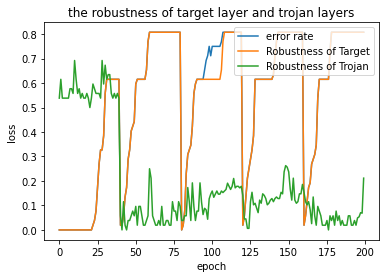

In [87]:
plt.plot(loss_per,label="error rate")
plt.plot(loss_rob_target,label="Robustness of Target")
plt.plot(loss_rob_trojan,label="Robustness of Trojan")
plt.legend(loc="upper right", ncol=1)
plt.title("the robustness of target layer and trojan layers")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

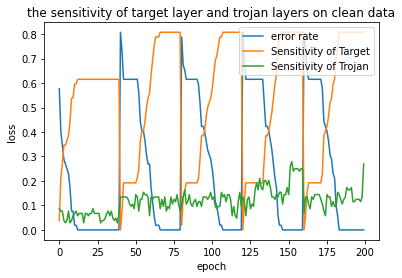

In [88]:
plt.plot(loss_mask,label="error rate")
plt.plot(loss_nat_target,label="Sensitivity of Target")
plt.plot(loss_nat_trojan,label="Sensitivity of Trojan")
plt.legend(loc="upper right", ncol=1)
plt.title("the sensitivity of target layer and trojan layers on clean data")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

In [27]:
print(loss_sequential_1)
print(loss_sequential_2)

[nan, nan, 0.4766346153846153, 0.5494230769230769, 0.5388461538461539]
[nan, nan, 0.20721153846153845, 0.20153846153846156, 0.2658653846153846]
